In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with np.load('prediction-challenge-02-data.npz') as fh:
    data_x = fh['data_x']
    data_y = fh['data_y']
    test_x = fh['test_x']

# TRAINING DATA: INPUT (x) AND OUTPUT (y)
# 1. INDEX: IMAGE SERIAL NUMBER (6000)
# 2. INDEX: COLOR CHANNELS (3)
# 3/4. INDEX: PIXEL VALUE (32 x 32)
print(data_x.shape, data_x.dtype)
print(data_y.shape, data_y.dtype)

# TEST DATA: INPUT (x) ONLY
print(test_x.shape, test_x.dtype)

# TRAIN MODEL ON data_x, data_y

# PREDICT prediction FROM test_x

# MAKE SURE THAT YOU HAVE THE RIGHT FORMAT
#assert prediction.ndim == 1
#assert prediction.shape[0] == 300

# AND SAVE EXACTLY AS SHOWN BELOW
#np.save('prediction.npy', prediction)

(6000, 3, 32, 32) float32
(6000,) int64
(300, 3, 32, 32) float32


# Display data

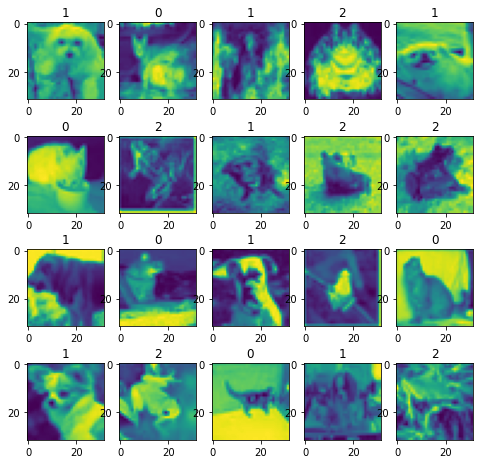

In [ ]:
fig, ax = plt.subplots(4, 5, figsize=(8, 8))
for i in range(20):
  ax[int(i/5),int(i%5)].imshow(data_x[i,0]) # only one map scale
  ax[int(i/5),int(i%5)].title.set_text(data_y[i])
plt.show()

In [ ]:
#classes types
np.unique(data_y) # figure shows 0 cat, 1 dog, 2 frog

array([0, 1, 2])

# Data processing

In [ ]:
# set training and validation set and test_set lengths
data_len = data_x.shape[0]
train_len, val_len = int(data_len * 0.9), int(data_len * 0.98)

#random indices data 
indices = np.random.permutation(data_x.shape[0])
train_idx, val_idx, test_idx = indices[:train_len], indices[train_len:val_len], indices[val_len:]

# make train, val and test set
train_x, train_y = data_x[:train_len], data_y[:train_len]
val_x, val_y = data_x[train_len:val_len], data_y[train_len:val_len]
intest_x, intest_y = data_x[val_len:], data_y[val_len:]

# Normalisation

In [ ]:
# Normalisation
#train_x = train_x / 255
#val_x = val_x / 255
#test_x = test_x / 255
print(len(train_x), len(val_x), len(intest_x))
print(val_len)
print(train_len)


5400 480 120
5880
5400


In [ ]:
# Data processing for pytorch
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_xt, train_yt, val_xt, val_yt, intest_xt, intest_yt = map(
    torch.tensor, (train_x, train_y, val_x, val_y, intest_x, intest_y)
)

bs = 200  # batch size
train_ds = TensorDataset(train_xt, train_yt)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(val_xt, val_yt)
valid_dl = DataLoader(valid_ds, batch_size=200)

#Define a Neural Network

Here we are doing **multi-class classification** so our NN will model **multi-class Bernauli probability distribution**.
So, we need a 
1. **softmax function** to assure that  our output predictions can indeed be interpreted as probability.
distribution. 
2. **Cross-entropy** as a loss function to maximise likelihood

Softmax function:

  input : type of classes  
  output: same shape as the input

** The implemetation of crossentropy() in pytorch includes softmax
logsoftmax + negative log-likelihood

Otherwise: we can do
LogSoftmax(x) := ln(softmax(x))CrossEntropyLoss(x, y) := NLLLoss(LogSoftmax(x), y)

**We have already normalised our data, so we not using Batch normalisation.**

**For batch normalisation**:

https://arxiv.org/abs/1502.03167

CLASS torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

1. By default, during training this layer keeps running estimates of its computed mean and variance, which are then used for normalization during evaluation. The running estimates are kept with a default momentum of 0.1.

2. If track_running_stats is set to False, this layer then does not keep running estimates, and batch statistics are instead used during evaluation time as well.
3.The update rule for running statistics here

new_estimate = (1 - momentum) * prev_running + momentum * current_step_estimate

**Implementation:**

torch.nn.Conv2d(n_input, n_output, kernel_size=3, padding=1, stride=stride, bias=False),

torch.nn.BatchNorm2d(n_output),

torch.nn.ReLU(),

torch.nn.Conv2d(n_output, n_output, kernel_size=3, padding=1, bias=False),

torch.nn.BatchNorm2d(n_output),

torch.nn.ReLU()


#Dropout:
https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf

For any layer l, r(l) is a vector of independent
Bernoulli random variables each of which has probability p of being 1. This vector is
sampled and multiplied element-wise with the outputs of that layer, y(l), to create the
(l)
thinned outputs y􏰆
. The thinned outputs are then used as input to the next layer.
So Drop out should be applied after ReLu()/activation function


Difference between torch.nn.Dropout and torch.nn.functional.Dropout.

1. Both are completely equivalent in terms of applying dropout and even though the differences in usage are not that big, there are some reasons to favour the nn.Dropout over nn.functional.dropout:

2. Dropout is designed to be only applied during training, so when doing predictions or evaluation of the model you want dropout to be turned off. The dropout module nn.Dropout conveniently handles this and shuts dropout off as soon as your model enters evaluation mode, while the functional dropout does not care about the evaluation / prediction mode. Even though you can set functional dropout to training=False to turn it off, it is still not such a convenient solution like with nn.Dropout.











## Style 1

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
  
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=2*2*128, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=3)

    def forward(self, x):
        out = self.pool(F.relu(self.conv1(x)))    #32*32--> 28*28-->14*14
        out = self.pool(F.relu(self.conv2(out))) #14*14 --> 10*10-->5*5
        out = self.pool(F.relu(self.conv3(out))) #14*14 --> 10*10-->5*5
        out = out.view(out.shape[0],-1)
        out = F.relu(self.fc1(out))
        #F.dropout(out3, p=0.5, training=True)
        out = F.relu(self.fc2(out))
        #F.dropout(out4, p=0.5, training=True)
        out = F.relu(self.fc3(out))
        return out # returning 5 outputs for layer analysis in future, use one variable
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)


F.dropout(out, p=0.5, training=True) 

## Style 2

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
            
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(num_features=64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
            
        )
        self.fc = nn.Sequential(
            #nn.BatchNorm1d(2*2*128),
            nn.Linear(in_features=7*7*64, out_features=128),
            nn.BatchNorm1d(num_features=128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            #nn.Linear(in_features=1028, out_features=128),
            #nn.ReLU(),
            nn.Linear(in_features=128, out_features=3),
            nn.BatchNorm1d(num_features=3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU()
            )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        

    def forward(self, x):
        out = self.pool(self.conv1(x))   #32*32--> 28*28-->14*14
        out = self.pool(self.conv2(out)) #14*14 --> 10*10-->5*5
        out = out.view(out.shape[0],-1)
        out = self.fc(out)
        return out # returning 5 outputs for layer analysis in future, use one variable
net = Net()
print(net)

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=3, bias=True)
    (4): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


# info for Conv2d or conv3d function:

**Error**:

**Given groups=1, weight of size [32, 3, 5, 5], expected input[30, 32, 14, 14] to have 3 channels, but got 32 channels instead.**

pytorch expects tensor dimensions to be in a different order: batch * channel * height * width. That is, the channel dimension should precede the width and height spatial dimensions.

We need to permute the dimensions of our input tensor to if not given in the perticular oder.
e.g. if given in order :  5000x5000x3 
model(inputs.permute(0, 3, 1, 2))

# Training:


# Define a Loss function and optimizer

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
from torch import nn
training_size = len(train_dl.dataset)
loss_epoch_trn_list, loss_epoch_val_list = [], [] # loss storage lists
current_epoch = 0 
for epoch in range(40):
  current_epoch = epoch + 1
  running_trn_loss, running_batch_trn_loss = 0.0 , 0.0
  print(f"\nEpoch {epoch+1}\n-------------------------------")
  
  # TRAINING
  net.train()

  for batch_num, (input, label) in enumerate(train_dl):
    #input, label = input.to(device), label.to(device)

    # prediction
    pred = net(input) 
    loss = criterion(pred, label) #evalute loss
    
    # backpropogation 
    loss.backward() 
    optimizer.step()
    optimizer.zero_grad() # zeroes the parameter gradients
    
    # statistics
    running_trn_loss += loss.item()
    running_batch_trn_loss += loss.item() 
         
    if batch_num % 25 == 24:
      current_index = (batch_num+1) * bs
      print(f"loss: {running_batch_trn_loss/(50 * bs) :>7f}  [{current_index:>5d}/{training_size:>5d}]")
      running_batch_trn_loss = 0
  
  # cummulative training loss after each epoch
  epoch_mean_trn_loss = running_trn_loss / training_size
  loss_epoch_trn_list.append(epoch_mean_trn_loss)
  print(f"Training avg loss: {loss_epoch_trn_list[-1]:>7f}")
  
  
  # VALIDATION
  net.eval()
  
  validation_size = len(valid_dl.dataset)
  running_val_loss, correct_prediction = 0, 0
  with torch.no_grad():
    for X, y in valid_dl:
      val_pred = net(X)
      val_loss = criterion(val_pred, y)
      running_val_loss += val_loss.item()
      correct_prediction += (y == torch.argmax(val_pred,dim=1)).float().sum().item()
  
  val_accuracy = correct_prediction / validation_size * 100
  epoch_mean_val_loss = running_val_loss / validation_size
  loss_epoch_val_list.append(epoch_mean_val_loss) # append to list
  print(f"Validation Accuracy: {(val_accuracy):>0.1f}%, validation avg loss: {loss_epoch_val_list[-1]:>8f}")

  #saving model for minimum validation loss
  if loss_epoch_val_list[-1] <= min(loss_epoch_val_list):
    print("model saved\n")
    torch.save(net, './best_cifar_net.pth')




Epoch 1
-------------------------------
loss: 0.002412  [ 5000/ 5400]
Training avg loss: 0.004791
Validation Accuracy: 50.2%, validation avg loss: 0.006345
model saved


Epoch 2
-------------------------------
loss: 0.002038  [ 5000/ 5400]
Training avg loss: 0.004070
Validation Accuracy: 64.2%, validation avg loss: 0.005518
model saved


Epoch 3
-------------------------------
loss: 0.001832  [ 5000/ 5400]
Training avg loss: 0.003658
Validation Accuracy: 65.2%, validation avg loss: 0.005163
model saved


Epoch 4
-------------------------------
loss: 0.001635  [ 5000/ 5400]
Training avg loss: 0.003287
Validation Accuracy: 69.0%, validation avg loss: 0.005220

Epoch 5
-------------------------------
loss: 0.001470  [ 5000/ 5400]
Training avg loss: 0.002936
Validation Accuracy: 63.5%, validation avg loss: 0.005022
model saved


Epoch 6
-------------------------------
loss: 0.001294  [ 5000/ 5400]
Training avg loss: 0.002580
Validation Accuracy: 68.5%, validation avg loss: 0.004854
model 

# error visualisation

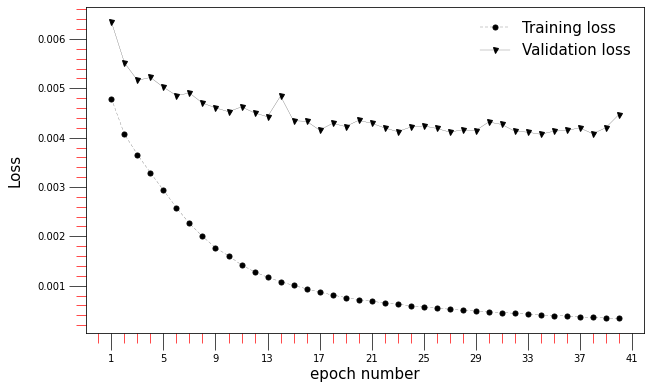

In [ ]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
fig,ax = plt.subplots(figsize=(10, 6))
x_points = np.arange(1, epoch+2, 1 )
x_points_ = np.arange(1, epoch+3, 4 )
ax.set_xticks(x_points_)
ax.set_xlabel('epoch number',fontsize=15, labelpad =3)
ax.xaxis.set_minor_locator(AutoMinorLocator(4))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', width=0.7,length=17,direction="out" , labelleft=True )
ax.tick_params(which='minor', width=0.7, length=10, color='r', direction="out")
ax.set_ylabel('Loss',fontsize=15, labelpad=15)
ax.plot(x_points, loss_epoch_trn_list , color = 'black', marker='o', markersize=5 , linestyle='dashed', dashes=(15, 10),linewidth=0.2) 
ax.plot(x_points, loss_epoch_val_list , color = 'black', marker='v', markersize=5 , linestyle='solid', linewidth=0.2) 
ax.legend(['Training loss','Validation loss' ], loc='best', fontsize=15, frameon=False)
plt.show()

# Load Network and generalisation error on test data

In [ ]:
#load model and continue training
PATH = './best_cifar_net.pth'
our_saved_model = torch.load(PATH)

In [ ]:
test_size = intest_xt.shape[0]
our_saved_model.eval()
with torch.no_grad():
  test_predi = our_saved_model(intest_xt)
  correct_pred = intest_yt.eq(torch.argmax(test_predi,dim=1))
  correct_pred = correct_pred.float().sum().item()
  nd_test_prediction = torch.argmax(test_predi,dim=1).numpy()
  test_accuracy = correct_pred / test_size * 100
  print(f"Testset Accuracy: {(test_accuracy):>0.1f}%")

Testset Accuracy: 71.7%


# further exploration

# Weight Initialisation

https://discuss.pytorch.org/t/custom-weight-initialization/20544/16


Net(
  (conv1): Sequential(

    (0): Conv1d(4, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  
  (dense): Sequential(

    
    (0): Linear(in_features=640, out_features=320, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=320, out_features=10, bias=True)
  )
)

net.conv1[0].weight.data = net.conv1[0].weight.data + K

In [ ]:
weights_4 = net.conv1.weight
bias_4 = net.conv1.bias
print(weights_4.shape)
print(bias_4.shape)